# Carga y evaluación de los modelos

Descomprimimos la carpeta con los modelos

# Pasos previos

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import seaborn as sns   
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2023-01-01'
fecha_inicio_test = '2023-01-02'
fecha_fin_test = '2023-05-01'

datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla


def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train


datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred, label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test, label=name, color='blue')
    ax.set_title(name)

def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(3150, 1) (3272, 1) (3028, 1) (3272, 1)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Redes neuronales

In [2]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

# LSTM

2/2 [==============================] - 0s 19ms/step
Tesla (TSLA)
RMSE:  6.566780593276882
MSE:  43.12260736023788
MAE:  5.094265208524816
R²:  0.7631687588024133


2/2 [==============================] - 0s 16ms/step
SP500 (^GSPC)
RMSE:  42.18586067435967
MSE:  1779.6468408364854
MAE:  33.23515050551466
R²:  0.7514075218370841


3/3 [==============================] - 0s 30ms/step
Bitcoin (BTC-USD)
RMSE:  819.5289304129286
MSE:  671627.6677837587
MAE:  595.3917661516854
R²:  0.9220728277793164


2/2 [==============================] - 0s 10ms/step
Petroleo (CL=F)
RMSE:  2.013593955309993
MSE:  4.054560616860943
MAE:  1.571461897629959
R²:  0.7735353364078785




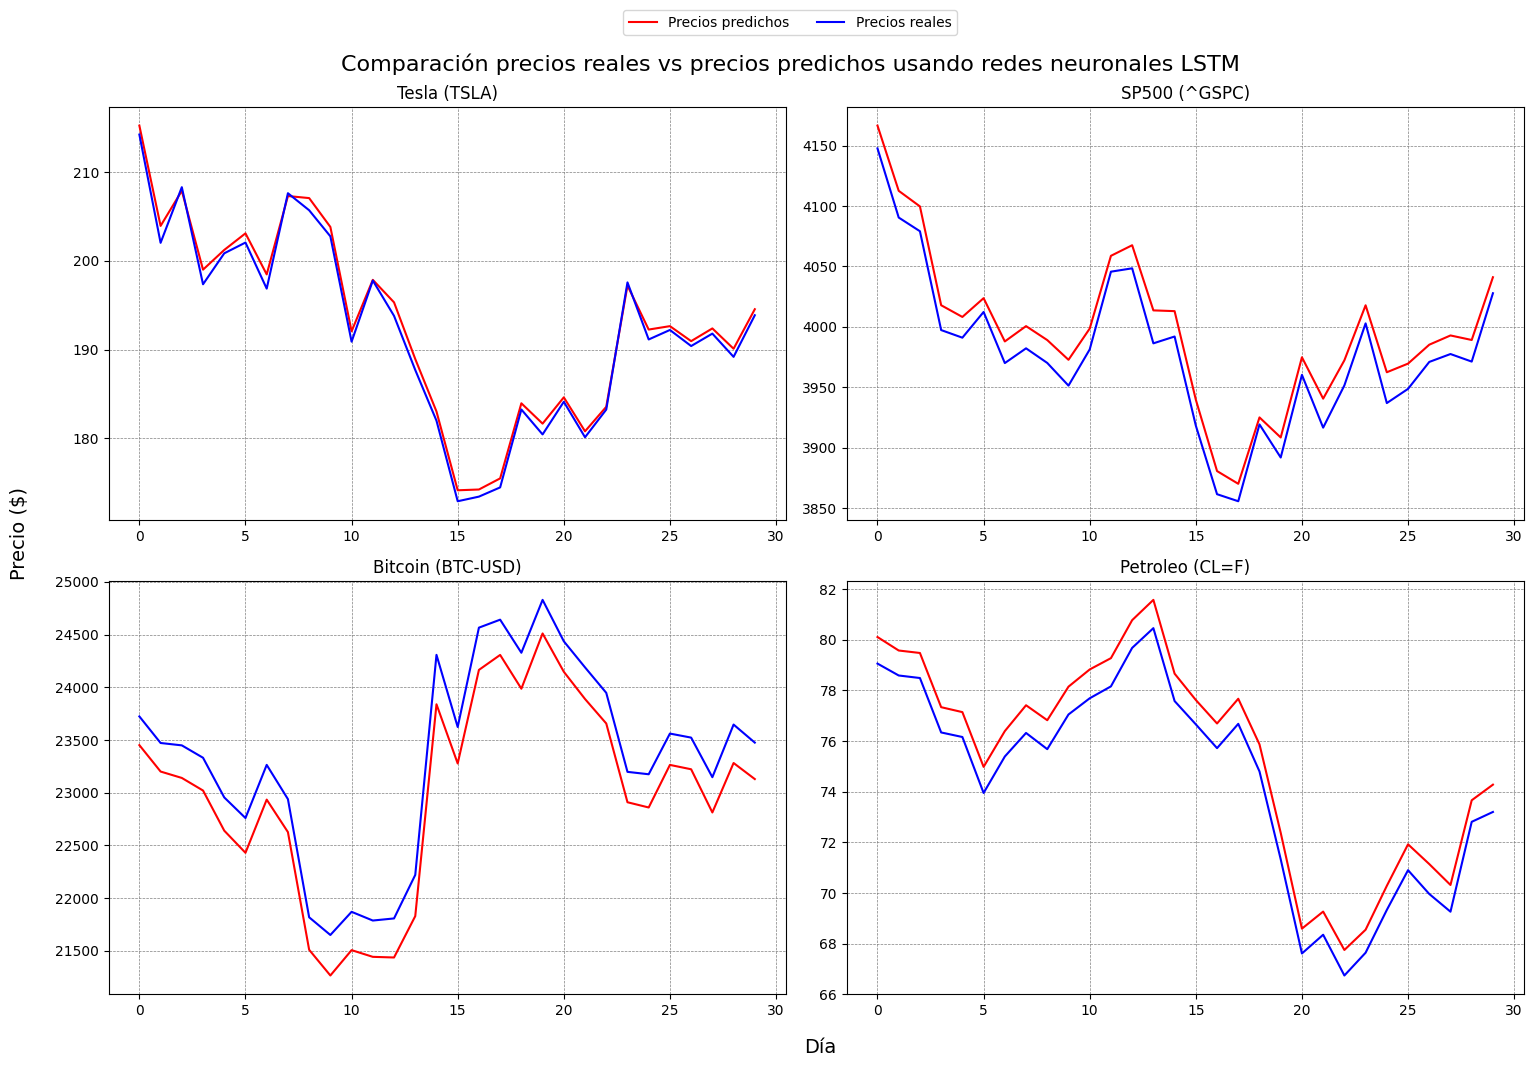

Tesla (TSLA)
RMSE:  14.47197788316981
MSE:  209.43814385095612
MAE:  12.274487304687502
R²:  -3.133071977263473


SP500 (^GSPC)
RMSE:  123.70542542965211
MSE:  15303.032280731219
MAE:  115.439794921875
R²:  -16.77349267016975


Bitcoin (BTC-USD)
RMSE:  1624.070001809853
MSE:  2637603.370778656
MAE:  1494.4859375
R²:  -1.4803294543455534


Petroleo (CL=F)
RMSE:  5.215824220060086
MSE:  27.204822294565407
MAE:  4.854124450683597
R²:  -1.4449705516081188




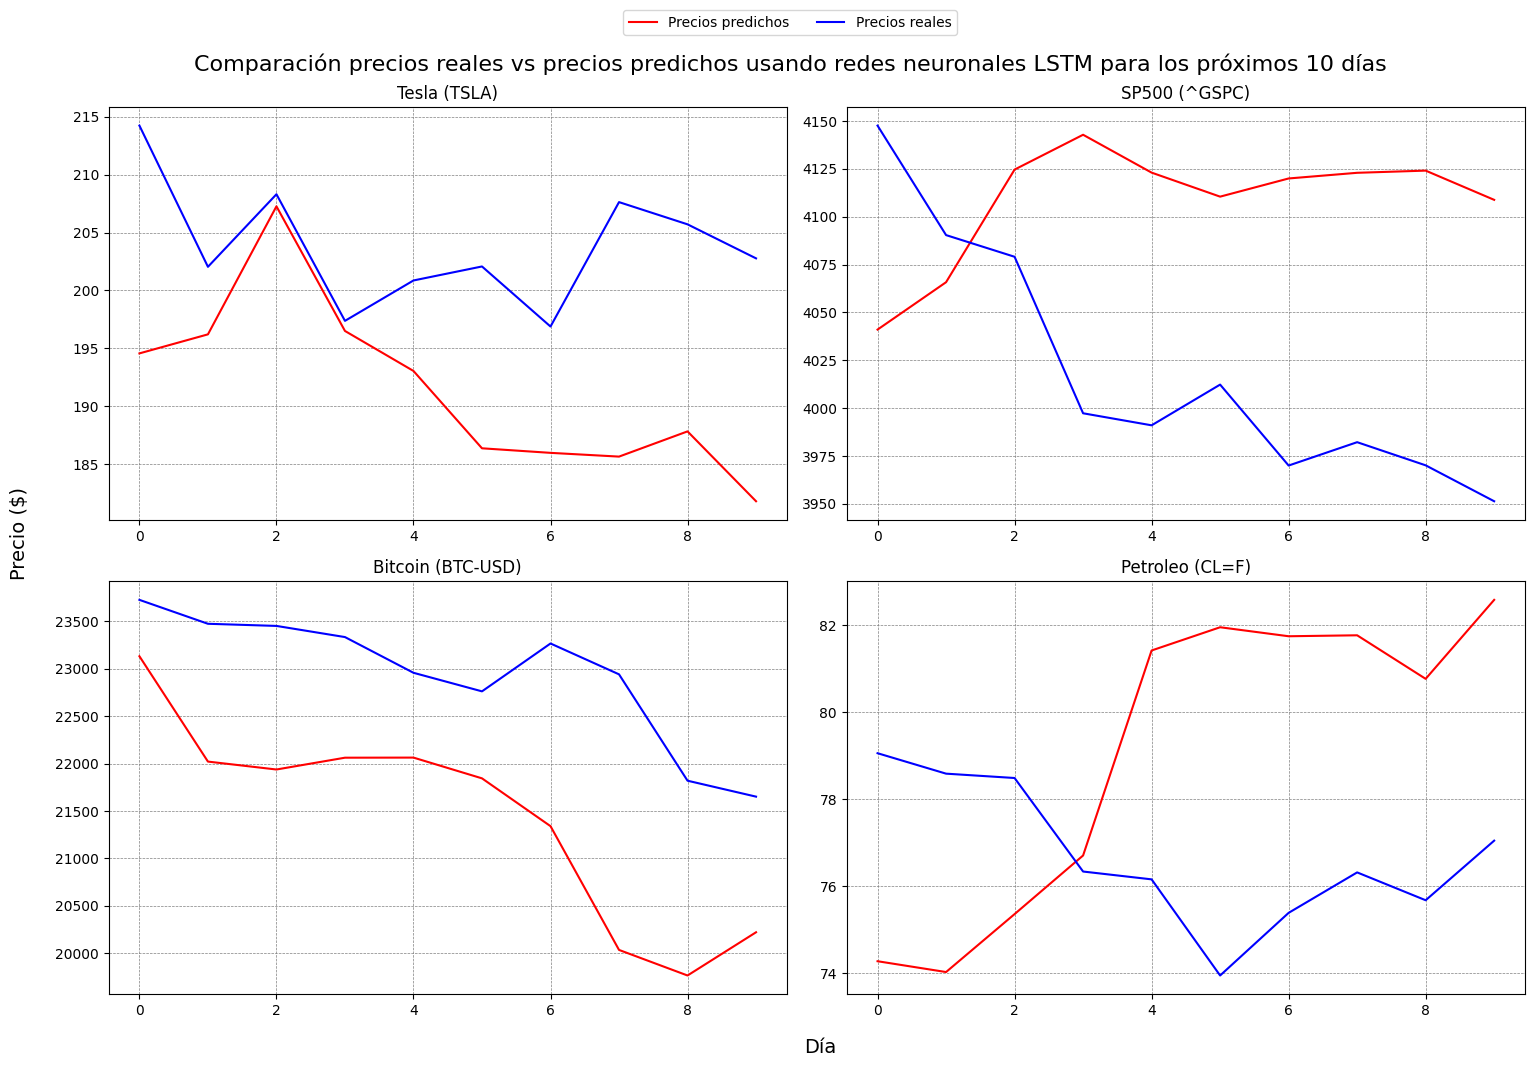

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = tf.keras.models.load_model('modelos/lstm_tesla.h5')
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_sp500 = tf.keras.models.load_model('modelos/lstm_sp500.h5')
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_bitcoin = tf.keras.models.load_model('modelos/lstm_bitcoin.h5')
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_petroleo = tf.keras.models.load_model('modelos/lstm_petroleo.h5')
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [4]:
lstm_tesla.summary()

Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_588 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_589 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_590 (LSTM)             (None, 256)               525312    
                                                                 
 dense_196 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [5]:
lstm_sp500.summary()

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_591 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_592 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_593 (LSTM)             (None, 256)               525312    
                                                                 
 dense_197 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [6]:
lstm_bitcoin.summary()

Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_594 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_595 (LSTM)             (None, None, 256)         525312    
                                                                 
 lstm_596 (LSTM)             (None, 256)               525312    
                                                                 
 dense_198 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [7]:
lstm_petroleo.summary()

Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_597 (LSTM)             (None, None, 128)         66560     
                                                                 
 lstm_598 (LSTM)             (None, None, 128)         131584    
                                                                 
 lstm_599 (LSTM)             (None, 128)               131584    
                                                                 
 dense_199 (Dense)           (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


# GRU

2/2 [==============================] - 0s 29ms/step
Tesla (TSLA)
RMSE:  6.6878791322135465
MSE:  44.72772728709742
MAE:  5.327604705212163
R²:  0.7683176925845232


2/2 [==============================] - 0s 8ms/step
SP500 (^GSPC)
RMSE:  38.39981021320207
MSE:  1474.5454244099383
MAE:  29.34120327818625
R²:  0.7931266985946036


3/3 [==============================] - 0s 39ms/step
Bitcoin (BTC-USD)
RMSE:  1076.0769267578476
MSE:  1157941.552300614
MAE:  935.7733058286517
R²:  0.870332925185359


2/2 [==============================] - 0s 27ms/step
Petroleo (CL=F)
RMSE:  4.300653999673718
MSE:  18.495624824909545
MAE:  3.989992141723636
R²:  -0.015735948290365176




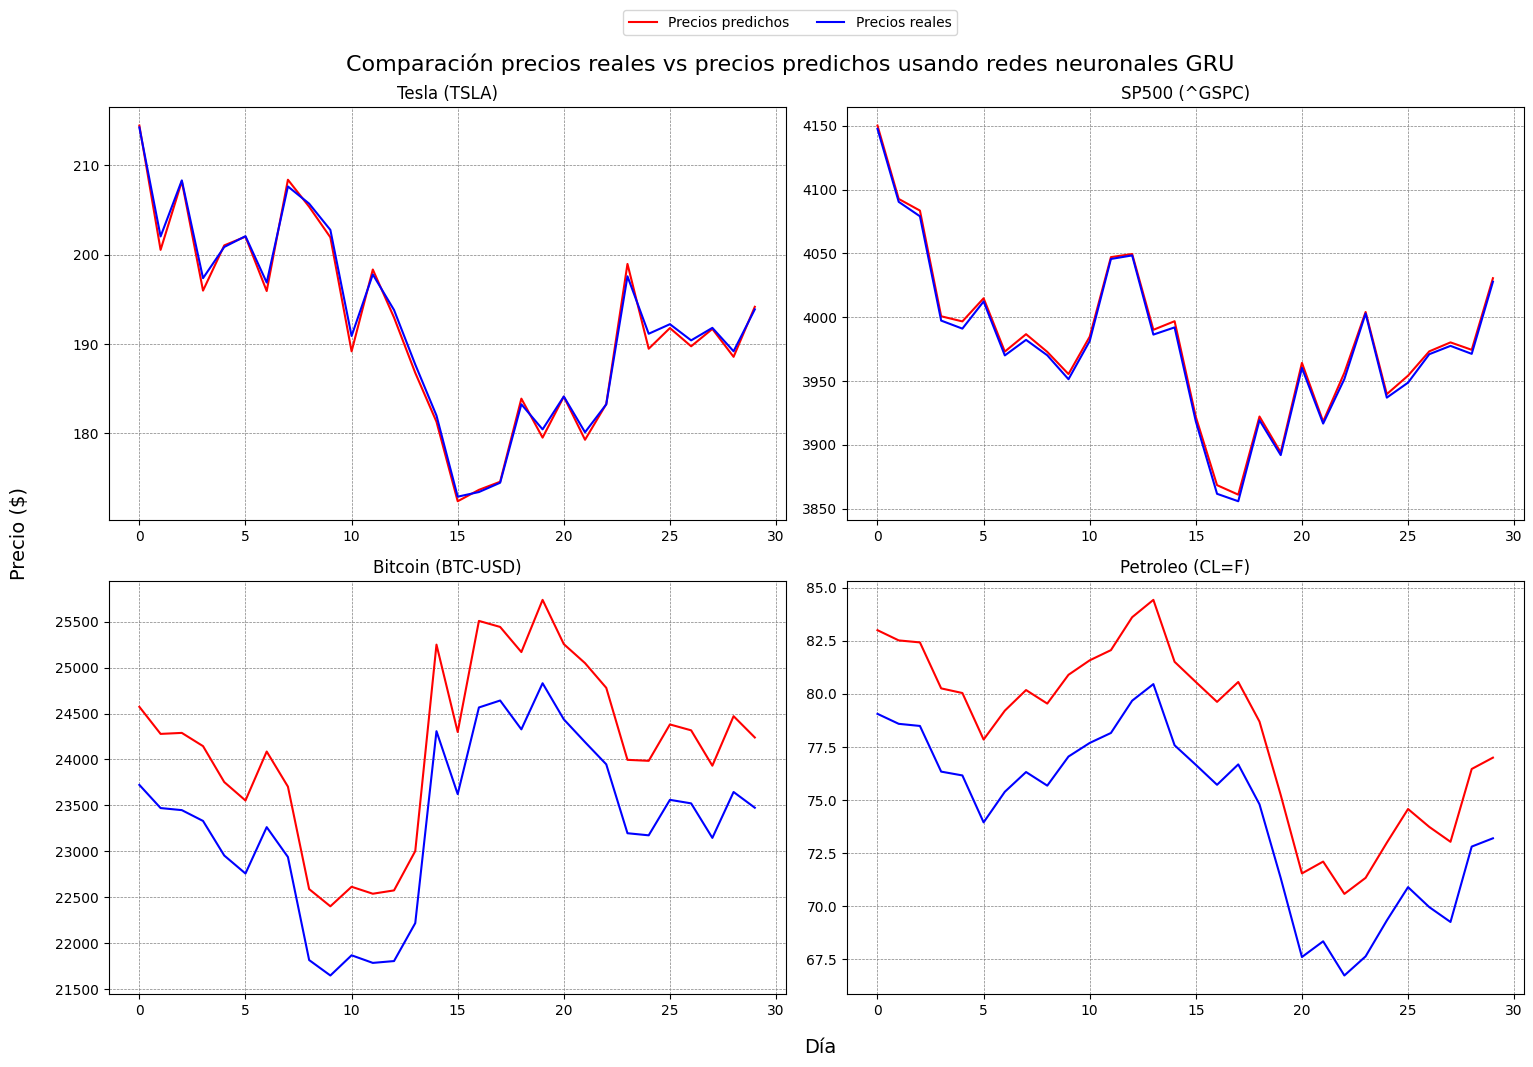

Tesla (TSLA)
RMSE:  7.00823068275416
MSE:  49.115297302696845
MAE:  5.865756225585935
R²:  -50.3179295199125


SP500 (^GSPC)
RMSE:  144.6584540138241
MSE:  20926.06831766966
MAE:  130.36999511718759
R²:  -514.695159624516


Bitcoin (BTC-USD)
RMSE:  6699.39776900267
MSE:  44881930.46731796
MAE:  5573.475390625
R²:  -3.6297654999055977


Petroleo (CL=F)
RMSE:  28.867852964033187
MSE:  833.3529347530396
MAE:  25.85121688842774
R²:  -4.937112253799442




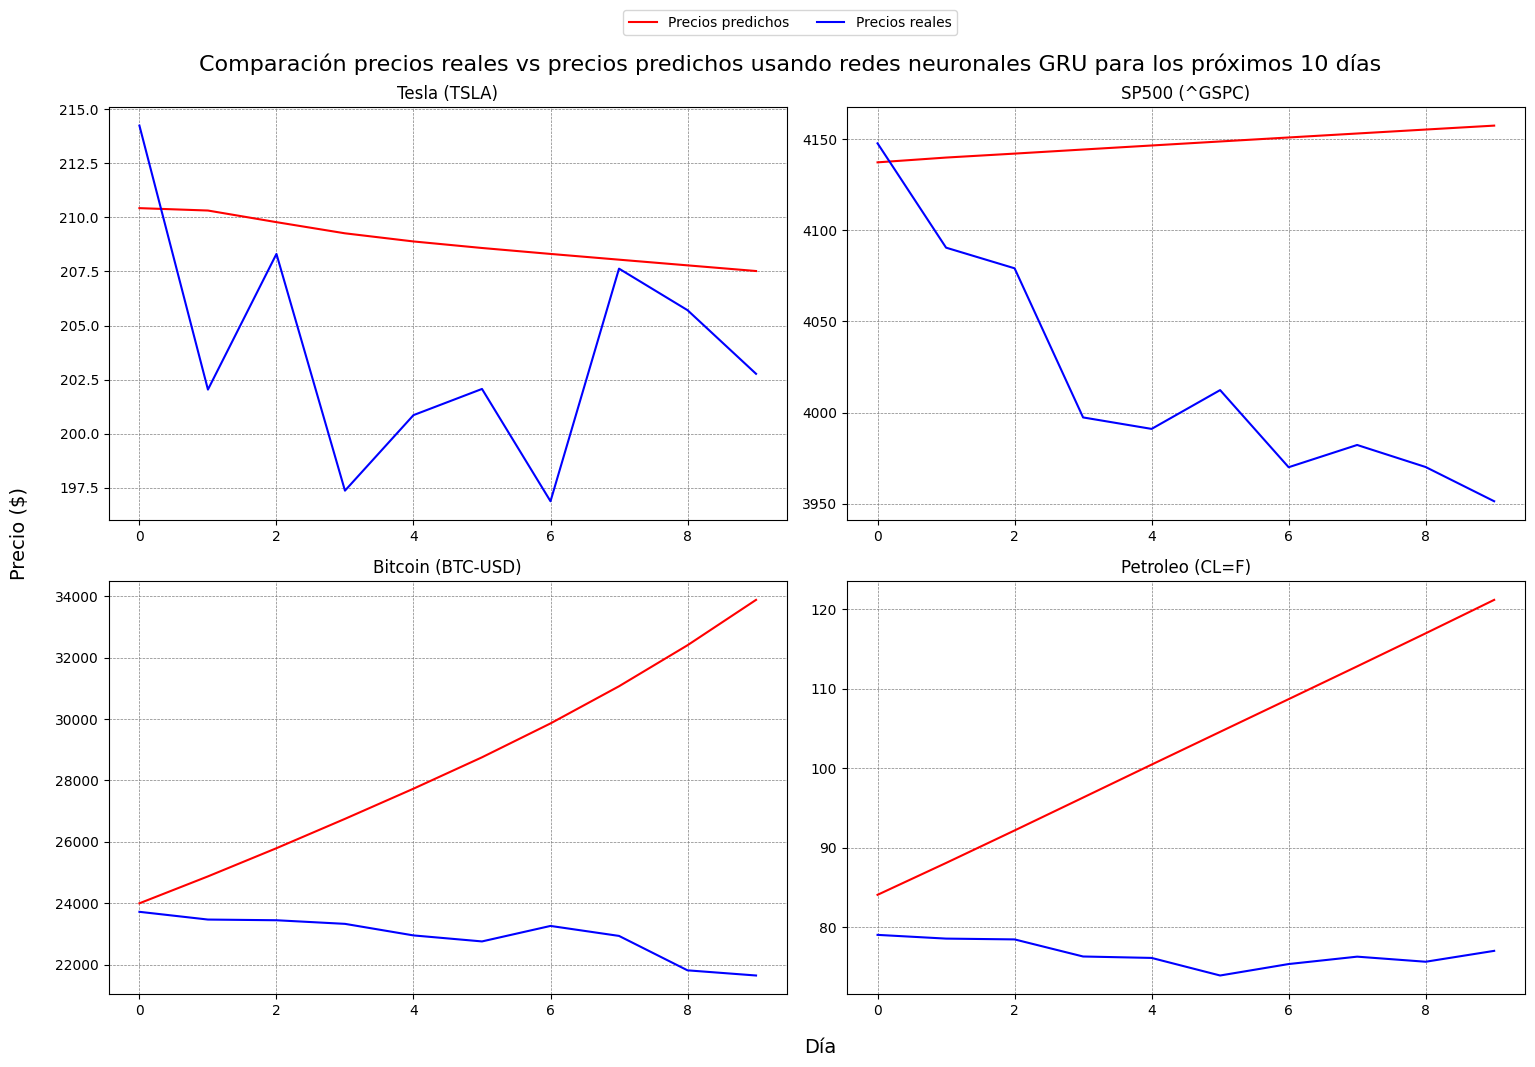

In [8]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = tf.keras.models.load_model('modelos/gru_tesla.h5')
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

gru_sp500 = tf.keras.models.load_model('modelos/gru_sp500.h5')
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

gru_bitcoin = tf.keras.models.load_model('modelos/gru_bitcoin.h5')
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

gru_petroleo = tf.keras.models.load_model('modelos/gru_petroleo.h5')
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [9]:
gru_tesla.summary()

Model: "sequential_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_604 (GRU)               (None, None, 512)         791040    
                                                                 
 gru_605 (GRU)               (None, None, 512)         1575936   
                                                                 
 gru_606 (GRU)               (None, 512)               1575936   
                                                                 
 dense_404 (Dense)           (None, 1)                 513       
                                                                 
Total params: 3,943,425
Trainable params: 3,943,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
gru_sp500.summary()

Model: "sequential_405"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_607 (GRU)               (None, 512)               791040    
                                                                 
 dense_405 (Dense)           (None, 1)                 513       
                                                                 
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [11]:
gru_bitcoin.summary()

Model: "sequential_406"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_601 (LSTM)             (None, None, 512)         1052672   
                                                                 
 gru_608 (GRU)               (None, 512)               1575936   
                                                                 
 dense_406 (Dense)           (None, 1)                 513       
                                                                 
Total params: 2,629,121
Trainable params: 2,629,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
gru_petroleo.summary()

Model: "sequential_407"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_609 (GRU)               (None, None, 512)         791040    
                                                                 
 gru_610 (GRU)               (None, None, 512)         1575936   
                                                                 
 gru_611 (GRU)               (None, 512)               1575936   
                                                                 
 dense_407 (Dense)           (None, 1)                 513       
                                                                 
Total params: 3,943,425
Trainable params: 3,943,425
Non-trainable params: 0
_________________________________________________________________


# LSTM + GRU

2/2 [==============================] - 0s 10ms/step
Tesla (TSLA)
RMSE:  7.394770738443929
MSE:  54.68263427414657
MAE:  5.843883439606311
R²:  0.7019548384449412


2/2 [==============================] - 0s 18ms/step
SP500 (^GSPC)
RMSE:  39.20608202276984
MSE:  1537.1168675761564
MAE:  30.229094860600462
R²:  0.7884910203686821


3/3 [==============================] - 0s 8ms/step
Bitcoin (BTC-USD)
RMSE:  710.8244788519264
MSE:  505271.4397351127
MAE:  520.492648349719
R²:  0.9426359320221593


2/2 [==============================] - 0s 19ms/step
Petroleo (CL=F)
RMSE:  1.7451716320652475
MSE:  3.0456240253652798
MAE:  1.4138861436110266
R²:  0.8273230545493038




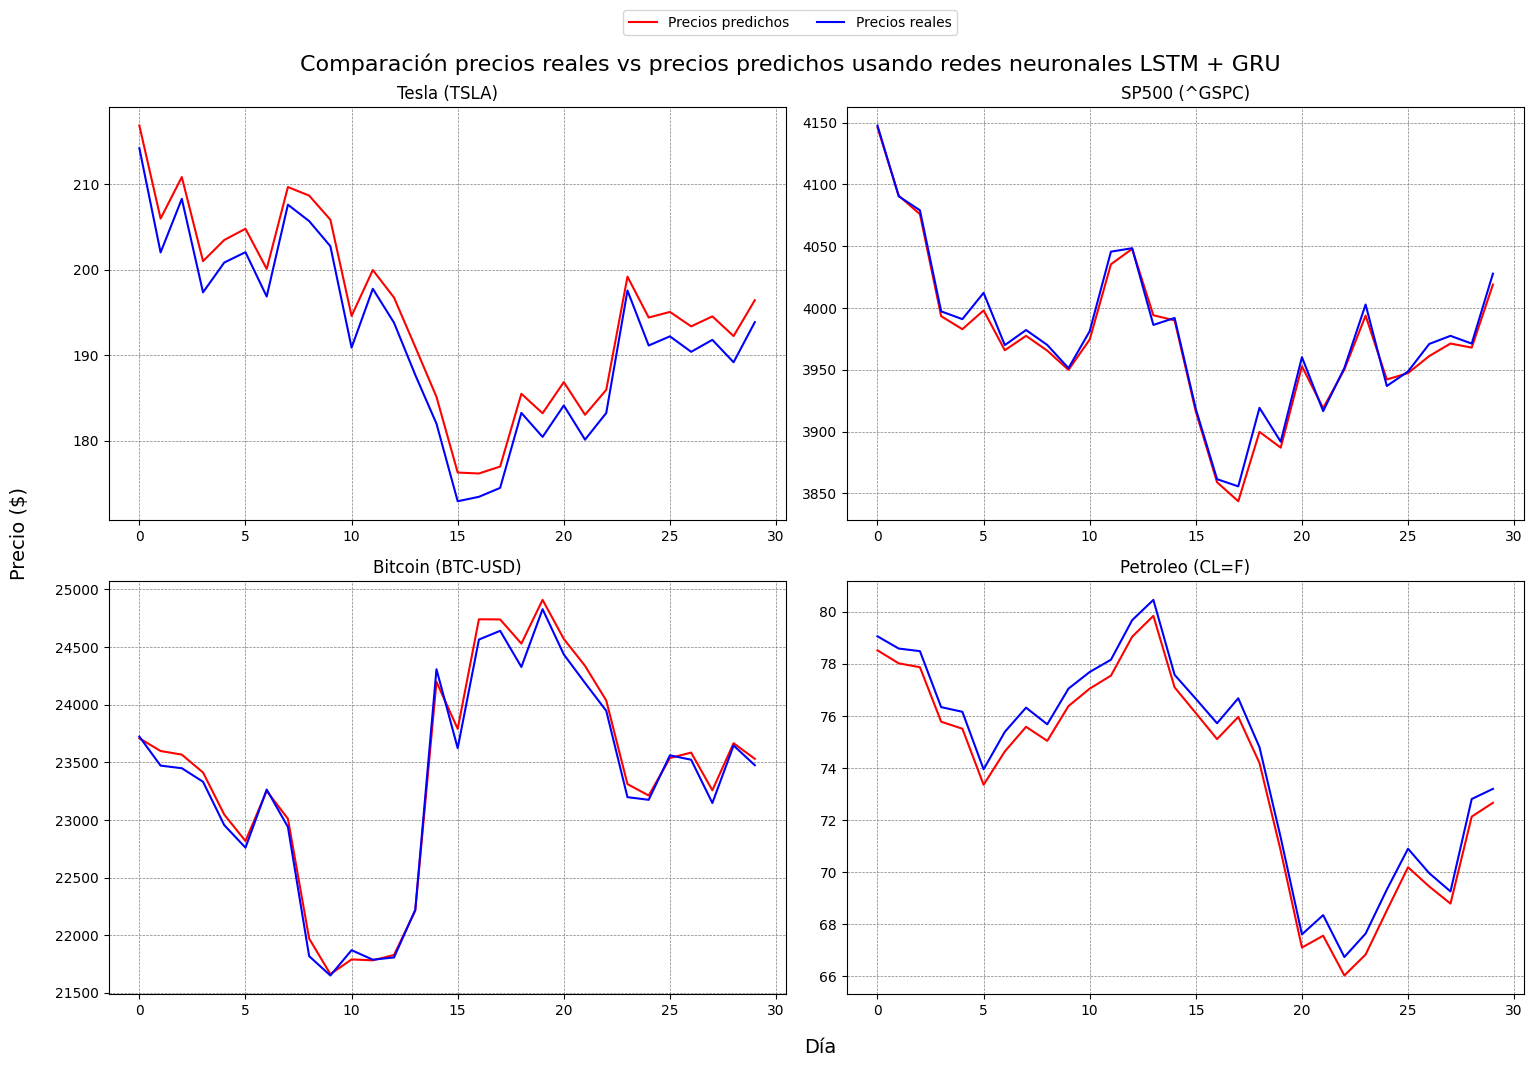

Tesla (TSLA)
RMSE:  22.66855005670214
MSE:  513.8631616732106
MAE:  20.652865600585933
R²:  -6.971888819094375


SP500 (^GSPC)
RMSE:  109.21376048256619
MSE:  11927.645478743336
MAE:  99.85031738281259
R²:  -77.41368314653498


Bitcoin (BTC-USD)
RMSE:  1061.227889224465
MSE:  1126204.632867813
MAE:  774.8185546875
R²:  -21.61533597508558


Petroleo (CL=F)
RMSE:  1.4995845112507964
MSE:  2.24875370638329
MAE:  1.1811042785644559
R²:  0.2963090332690699




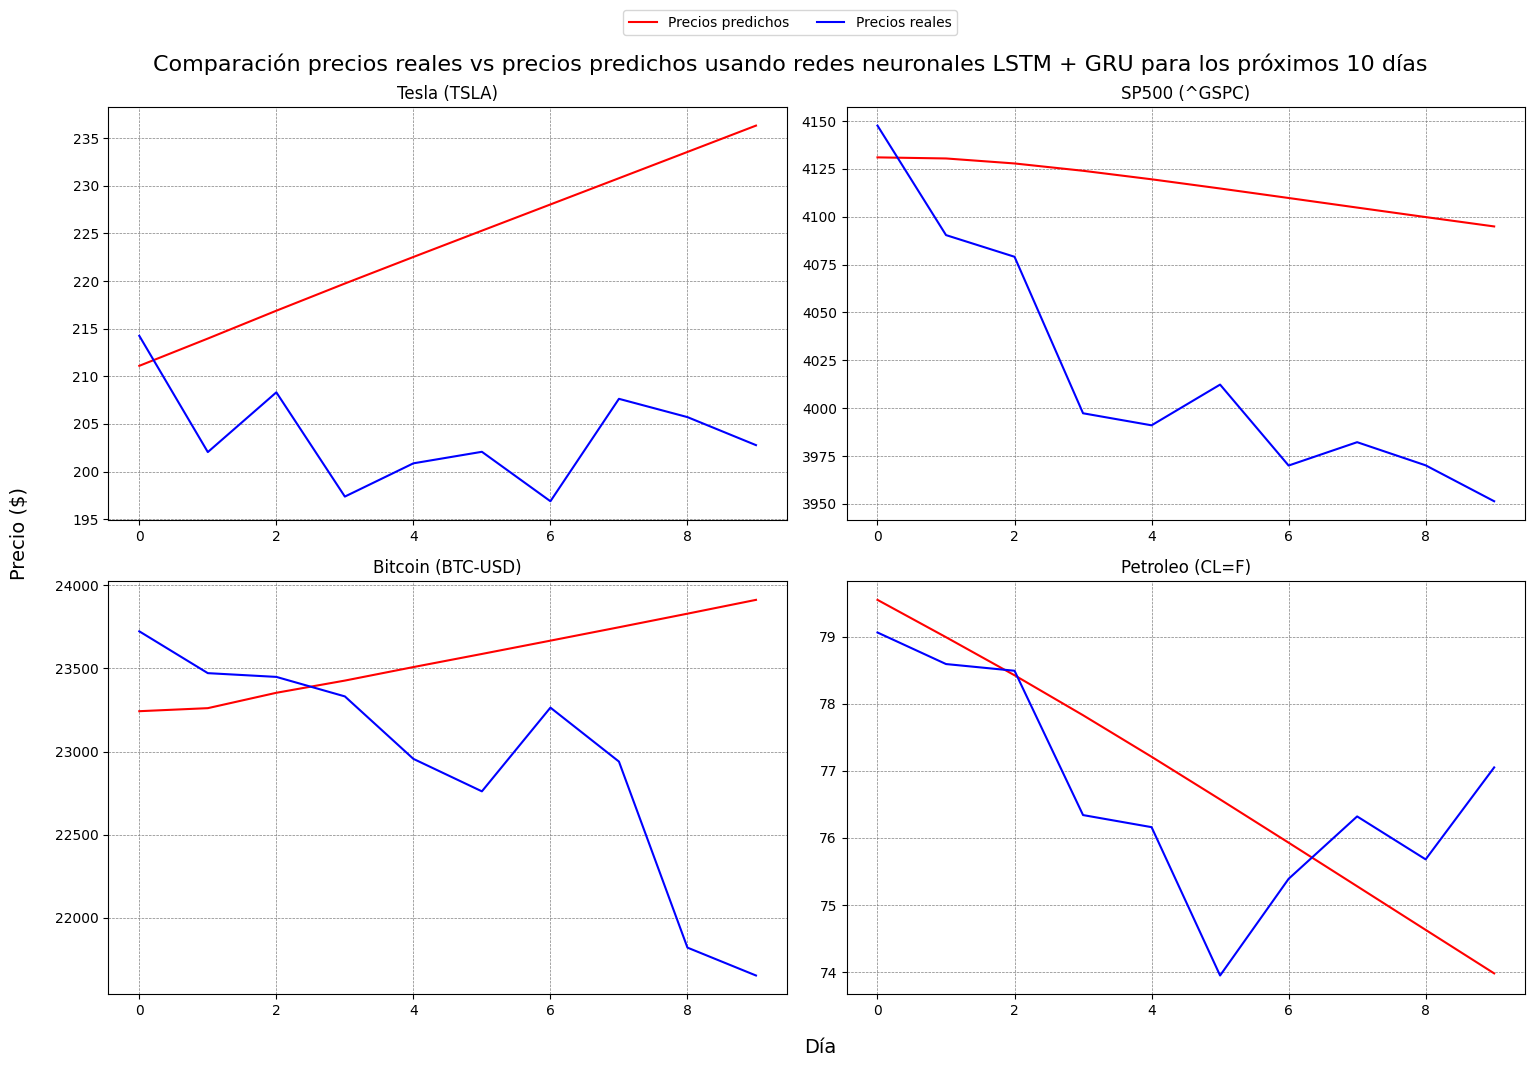

In [13]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = tf.keras.models.load_model('modelos/lstm_gru_tesla.h5')
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_gru_sp500 = tf.keras.models.load_model('modelos/lstm_gru_sp500.h5')
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_gru_bitcoin = tf.keras.models.load_model('modelos/lstm_gru_bitcoin.h5')
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_gru_petroleo = tf.keras.models.load_model('modelos/lstm_gru_petroleo.h5')
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [14]:
lstm_gru_tesla.summary()

Model: "sequential_604"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_994 (LSTM)             (None, None, 256)         264192    
                                                                 
 gru_1004 (GRU)              (None, 256)               394752    
                                                                 
 dense_604 (Dense)           (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
lstm_gru_sp500.summary()

Model: "sequential_605"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_995 (LSTM)             (None, None, 256)         264192    
                                                                 
 lstm_996 (LSTM)             (None, None, 256)         525312    
                                                                 
 gru_1005 (GRU)              (None, None, 256)         394752    
                                                                 
 gru_1006 (GRU)              (None, 256)               394752    
                                                                 
 dense_605 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,579,265
Trainable params: 1,579,265
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_gru_bitcoin.summary()

Model: "sequential_606"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_997 (LSTM)             (None, None, 128)         66560     
                                                                 
 gru_1007 (GRU)              (None, 128)               99072     
                                                                 
 dense_606 (Dense)           (None, 1)                 129       
                                                                 
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_gru_petroleo.summary()

Model: "sequential_607"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_998 (LSTM)             (None, None, 512)         1052672   
                                                                 
 gru_1008 (GRU)              (None, 512)               1575936   
                                                                 
 dense_607 (Dense)           (None, 1)                 513       
                                                                 
Total params: 2,629,121
Trainable params: 2,629,121
Non-trainable params: 0
_________________________________________________________________
